In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Initial exploration

In [143]:
df = pd.read_csv("./Data/dataset_mood_smartphone.csv")
df = df.dropna(axis=0, how='any')
df.head()

,Unnamed: 0,id,time,variable,value
0,1,AS14.01,2014-02-26 13:00:00.000,mood,6.0
1,2,AS14.01,2014-02-26 15:00:00.000,mood,6.0
2,3,AS14.01,2014-02-26 18:00:00.000,mood,6.0
3,4,AS14.01,2014-02-26 21:00:00.000,mood,7.0
4,5,AS14.01,2014-02-27 09:00:00.000,mood,6.0


In [144]:
variables = np.unique(df.variable.values)
p = variables.shape[0]

time_points = np.unique(df.time.values)
T = time_points.shape[0]

n_response = np.sum([df.variable.values == 'mood'])

ids = np.unique(df.id.values)
n_ids = ids.shape[0]

id_df_list = [df[df.id == ids[i]] for i in range(n_ids)]

mood_timestamps = df.time[df.variable == 'mood']

In [145]:
print(p, T, n_response, n_ids)

timestamp = mood_timestamps[125]
t1 = mood_timestamps[1]
t2 = mood_timestamps[2]

response_times = df.time[df.variable == 'mood'].values
print(response_times)

mood_times = df.time[df.variable == 'mood'].values
mood_measurements = df.value[df.variable == 'mood'].values
measurement_types = np.unique(df.variable[df.variable != 'mood'].values).tolist()
measurement_df = df[df.variable != 'mood']
measurement_times = measurement_df.time.values
X = np.zeros((len(measurement_types), mood_measurements.shape[0]))
i = 0

print(np.nonzero(np.isin(df.variable.values, measurement_types[2]))[0])
print(measurement_types)

mean_types = np.array(['activity', 'circumplex.valence', 'circumplex.arousal'])
sum_types = np.array(list(filter(lambda x: x not in mean_types, measurement_types)))

print(sum_types)

19 336907 5641 27
['2014-02-26 13:00:00.000' '2014-02-26 15:00:00.000'
 '2014-02-26 18:00:00.000' ..., '2014-05-30 19:00:00.000'
 '2014-05-30 20:00:00.000' '2014-05-31 12:00:00.000']
[234593 234594 234595 ..., 308866 308867 308868]
['activity', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call', 'circumplex.arousal', 'circumplex.valence', 'screen', 'sms']
['appCat.builtin' 'appCat.communication' 'appCat.entertainment'
 'appCat.finance' 'appCat.game' 'appCat.office' 'appCat.other'
 'appCat.social' 'appCat.travel' 'appCat.unknown' 'appCat.utilities'
 'appCat.weather' 'call' 'screen' 'sms']


In [146]:
def time_earlier(t1, t2):
    year1 = int(t1[0:4])
    year2 = int(t2[0:4])
    if year1 == year2:
        month1 = int(t1[5:7])
        month2 = int(t2[5:7])
        if month1 == month2:
            day1 = int(t1[8:10])
            day2 = int(t2[8:10])
            if day1 == day2:
                hour1 = int(t1[11:13])
                hour2 = int(t2[11:13])
                if hour1 == hour2:
                    min1 = int(t1[14:16])
                    min2 = int(t2[14:16])
                    if min1 == min2:
                        sec1 = int(t1[17:19])
                        sec2 = int(t2[17:19])
                        if sec1 == sec2:
                            subsec1 = int(t1[20:23])
                            subsec2 = int(t2[20:23])
                            return subsec1 <= subsec2
                        else:
                            return sec1 < sec2
                    else:
                        return min1 < min2

                else:
                    return hour1 < hour2

            else:
                return day1 < day2
        else:
            return month1 < month2
    else:
        return year1 < year2

In [147]:
def time_difference(t1, t2):
    year1 = int(t1[0:4])
    year2 = int(t2[0:4])
    month1 = int(t1[5:7])
    month2 = int(t2[5:7])
    day1 = int(t1[8:10])
    day2 = int(t2[8:10])
    hour1 = int(t1[11:13])
    hour2 = int(t2[11:13])
    min1 = int(t1[14:16])
    min2 = int(t2[14:16])
    sec1 = int(t1[17:19])
    sec2 = int(t2[17:19])
    subsec1 = int(t1[20:23])
    subsec2 = int(t2[20:23])
    datetime1 = datetime.datetime(year1, month1, day1, hour1, min1, sec1, subsec1*1000)
    datetime2 = datetime.datetime(year2, month2, day2, hour2, min2, sec2, subsec2*1000)
    return (datetime2 - datetime1).total_seconds()

time_difference(mood_timestamps[1], mood_timestamps[0])

-7200.0

# Sum between recorded respones

In [154]:
def create_time_series(df):
    mood_times = df.time[df.variable == 'mood'].values
    mood_values = df.value[df.variable == 'mood'].values
    n = mood_values.shape[0]

    unique_mt = np.unique(df.variable[df.variable != 'mood'].values).tolist()
    measurement_types = df.variable.values[df.variable != 'mood']
    measurement_values = df.value.values[df.variable != 'mood']
    measurement_times = df.time.values[df.variable != 'mood']
    l = measurement_times.shape[0]

    mean_types = np.array(['activity', 'circumplex.valence', 'circumplex.arousal'])
    sum_types = np.array(list(filter(lambda x: x not in mean_types, unique_mt)))

    X = np.zeros((len(unique_mt), n))
    indices_to_drop = np.array([])
    j = 0
    for m_time in mood_times:
        earlier_time_indices = np.array([k for k in range(l)
                                         if time_earlier(measurement_times[k], m_time)
                                         and k not in indices_to_drop])
        if len(earlier_time_indices) == 0:
            continue
        earlier_types = measurement_types[earlier_time_indices]
        i = 0
        for m_type in unique_mt:
            earlier_measurement_indices = np.nonzero(np.isin(earlier_types, m_type))[0]
            if len(earlier_measurement_indices) != 0:
                measurement_indices = earlier_time_indices[earlier_measurement_indices]
                if m_type in sum_types:
                    # Sum all measurement types that should be added up
                    X[i, j] = np.sum(measurement_values[measurement_indices])
                elif m_type in mean_types:
                    X[i, j] = np.mean(measurement_values[measurement_indices])
                indices_to_drop = np.concatenate((indices_to_drop, measurement_indices))
            i += 1
        j += 1

    y = mood_values

    return X, y

In [155]:
df = pd.read_csv("./Data/dataset_mood_smartphone.csv")
df = df.dropna(axis=0, how='any')
ids = np.unique(df.id.values)
user_df = df[df.id == ids[0]]
X, y = create_time_series(user_df)

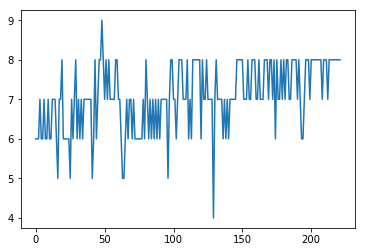

IndexError: index 18 is out of bounds for axis 0 with size 18

In [156]:
plt.plot(np.arange(len(y)), y)
plt.show()

print(np.sum(X[18,:]))
print(measurement_types)
print(np.sum(user_df.value.values[user_df.variable == 'sms']))

In [157]:
def shift_and_add_time(df, X, y):
    timestamps = df.time.values[df.variable == 'mood']
    t_delta = np.array([time_difference(timestamps[i], timestamps[i+1]) for i in range(y.shape[0] - 1)])
    print(t_delta.shape)
    sX = X[:, :-1]
    print(sX.shape)
    sX = np.vstack((sX, t_delta))
    sy = y[1:]
    
    return sX, sy

In [158]:
sX, sy = shift_and_add_time(user_df, X, y)
print(sX[:,0])

(221,)
(18, 221)
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.70000000e+01  -1.00000000e+00   0.00000000e+00
   0.00000000e+00   7.00000000e+00   7.20000000e+03]


In [159]:
measurement_types
cols = np.concatenate((measurement_types, np.array(['time', 'mood'])))
data = np.vstack((sX, sy)).T
proc_df = pd.DataFrame(data=data, columns=cols)
proc_df.head()
proc_df.to_csv('processed_data.csv', index=False)

# Recurrent Neural Network

# Additional code

In [ ]:
def df_timesplit(df):
    ret_df = df
    ret_df.insert(2, 'date', [ret_df.iloc[i].time[0:10] for i in range(len(ret_df))])
    ret_df.insert(3, 'hour', [ret_df.iloc[i].time[11:] for i in range(len(ret_df))])
    ret_df.drop(['time'], axis=1)
    return ret_df

# Average of single days

In [8]:
def extract_sum(var_name, days):
    array = [days[i][days[i].variable == var_name] for i in range(len(days))]
    total = [np.sum(array[i].value) for i in range(len(array))]
    return total


def extract_user_data(user_id, raw_df):
    split_df = pd.DataFrame(raw_df.time.str.split(' ', 1).tolist(), columns=['day', 'time'])
    df = raw_df.drop('time', axis=1)
    df.insert(2, 'day', split_df.day.tolist())
    df.insert(3, 'time', split_df.time.tolist())
    
    unique_days = df.day.unique().tolist()
    days = [df[df.day == unique_days[i]] for i in range(len(unique_days))]
    
    moods = [days[i][days[i].variable == 'mood'] for i in range(len(days))]
    response = [np.mean(moods[i].value) for i in range(len(moods))]
    
    total_calls = extract_sum('call', days)
    total_texts = extract_sum('sms', days)
    total_screen_time = extract_sum('screen', days)
    total_builtin = extract_sum('appCat.builtin', days)
    total_communication = extract_sum('appCat.communication', days)
    total_entertainment = extract_sum('appCat.entertainment', days)
    total_finance = extract_sum('appCat.finance', days)
    total_game = extract_sum('appCat.game', days)
    total_office = extract_sum('appCat.office', days)
    total_other = extract_sum('appCat.other', days)
    total_social = extract_sum('appCat.social', days)
    total_travel = extract_sum('appCat.travel', days)
    total_unknown = extract_sum('appCat.unknown', days)
    total_utilities = extract_sum('appCat.utilities', days)
    total_weather = extract_sum('appCat.weather', days)
    
    y = np.array(response[1:])
    x = np.array([total_calls[:-1], total_texts[:-1], total_screen_time[:-1], total_builtin[:-1]
             , total_communication[:-1], total_entertainment[:-1], total_finance[:-1]
             , total_game[:-1], total_office[:-1], total_social[:-1]
             , total_travel[:-1], total_utilities[:-1], total_weather[:-1]]).T
    
    return x,y

In [10]:
full_df = pd.read_csv('./Data/dataset_mood_smartphone.csv')
id_list = full_df.id.unique()
train_ids = id_list[:18]

x,y = extract_user_data(train_ids[1], full_df)

for i in range(len(train_ids)):
    x,y = extract_user_data(train_ids[i], full_df)
    if i == 0:
        X, Y = x, y
    else:
        X = np.concatenate((X, x))
        Y = np.concatenate((Y, y))
        
np.savetxt('x.txt', X)
np.savetxt('y.txt', Y)

(2016, 13)
(2016,)


# Linear Regression

## Change to R Kernel

In [1]:
data <- read.table('x.txt', col.names=c('call', 'texts', 'screen_time', 'builtin', 'com', 'ent', 'fin',
                                        'game', 'office', 'social', 'travel', 'util', 'weather'))
y <- read.table('y.txt', col.names = c('response'))
data['response'] <- y[['response']]

model <- lm(response ~ (.)^2, data=data)
summary(model)


Call:
lm(formula = response ~ (.)^2, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6522  0.0000  0.0000  0.0000  0.4464 

Coefficients: (2 not defined because of singularities)
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          6.301e+00  1.287e-01  48.955  < 2e-16 ***
call                 5.743e-03  1.748e-03   3.286 0.001037 ** 
texts                3.837e-02  9.389e-03   4.086 4.59e-05 ***
screen_time         -3.171e-03  9.297e-04  -3.411 0.000663 ***
builtin              3.131e-03  8.813e-04   3.553 0.000392 ***
com                  3.823e-03  1.080e-03   3.541 0.000409 ***
ent                 -9.688e-03  4.500e-03  -2.153 0.031469 *  
fin                  8.654e-01  2.670e-01   3.241 0.001214 ** 
game                 9.418e-02  4.627e-02   2.036 0.041950 *  
office               4.775e-02  2.043e-02   2.338 0.019521 *  
social               3.801e-03  1.402e-03   2.711 0.006775 ** 
travel               8.278e-02  4.034e-02  